In [449]:

%reset -f

In [402]:

from IPython.display import display, Math

## 1. Setup

### 1.1. Common Python modules

In [450]:
import matplotlib.pyplot as plt
import numpy as np

### 1.2. Ubermag modules

In [451]:
import discretisedfield as df
import micromagneticmodel as mm

Calcs.

In [452]:
import oommfc as oc

In [453]:
oc.runner.runner.status

Running OOMMF (TclOOMMFRunner)[2024/05/17 16:17]... (6.1 s)
OOMMF found and running.


0

### 1.3. System Names

In [484]:
system_spinchain_name = 'PrimarySpinchain'

## 2. Primary spin chain

In [485]:
system_spinchain = mm.System(name=system_spinchain_name)

### 2.1. Energy equation

In the [energy documentation](https://ubermag.github.io/api/_autosummary/micromagneticmodel.Energy.html#micromagneticmodel.Energy) we see that the *energy terms* are stored in a container class `mm.Energy(terms=None)`. This container is fundamentally a list of children and siblings that inherit from the `mm.EnergyTerm(**kwargs)` [parent class](https://ubermag.github.io/api/_autosummary/micromagneticmodel.EnergyTerm.html#micromagneticmodel.EnergyTerm).

We have a few options for how we build our energy equation:
1. We define an empty list and append each term to the list through the `append` method.
2. We define each `EnergyTerm` object and then combine them into a list: 
- `energy_terms = [term1, term2, term3]`.
- `energy_terms = term1 + term2 + term3`.

It's then a simple matter to do `system.energy = mm.Energy(terms=energy_terms)`.

In [464]:
spinchain_energy_terms = None

#### 2.1.1. Static zeeman energy

[Documentation page](https://ubermag.github.io/api/_autosummary/micromagneticmodel.Zeeman.html#micromagneticmodel.Zeeman). 

It's important to note that:
- This term covers both static, *i.e.* $\mathbf{H}_{0}$, and dynamic, *i.e.* $\mathbf{h}_{(x,t)}$, magnetic fields.
- If one wants to include more than one `mm.Zeeman()` in the same region then these Zeeman energies **must** be given different names.

In [497]:
# Align along the z-direction
spinchain_H0 = (0, 0, 0.1)  # Zeeman energy (T) 

In [498]:
# Convert to a tuple with required units if initial values were given in (T)
spinchain_H0 = tuple([x/mm.consts.mu0 for x in spinchain_H0])  # Zeeman energy (A/m)

In [499]:
# Create static Zeeman energy term
spinchain_zeeman_static = mm.Zeeman(H=spinchain_H0, name='ZeemanStatic')

# First term must be an EnergyTerm so we use assignment here, not appending
spinchain_energy_terms = spinchain_zeeman_static 

In [413]:
# Print equation of Zeeman energy
# spinchain_zeeman_static

#### 2.1.2. Dynamic zeeman energy

See comments for Section 2.1.1.

First we define the constants. Note that if we aren't using a `func` to define any oscillatory behaviours then we simply return to the *ZeemanStatic* case.

In [494]:
# Pumping field strength (T)
spinchain_h0 = (3e-3, 0, 0)

# Driving (cut-off) frequency (Hz)
spinchain_freq = 15e9

# Time to adjust the phase (time shift) of a wave [t - t0] (s)
spinchain_timeshift = 0  # don't want any offset

# Time steps to evaluate at (s)
stepsize = 1e-15

If our initial pumping field strength was given in $T$ then we need to convert to a tuple in the required units $A/m$.

In [495]:
spinchain_h0 = tuple([x/mm.consts.mu0 for x in spinchain_h0])  # Zeeman energy (A/m)

Now we can create the dynamic Zeeman energy term, give it an appropriate name to uniquely identify it, and append to the region's `EnergyTerm` container.

In [496]:
spinchain_zeeman_dynamic = mm.Zeeman(H=spinchain_h0, 
                                    name='ZeemanDynamic',
                                    func='sin',
                                    f=spinchain_freq,
                                    t0=spinchain_timeshift,
                                    dt=stepsize)

# Append to EnergyTerm
spinchain_energy_terms += spinchain_zeeman_dynamic

In [417]:
# Print equation of Zeeman energy
# spinchain_zeeman_dynamic

#### 2.1.3. Heisenberg exchange energy

[Documentation page](https://ubermag.github.io/api/_autosummary/micromagneticmodel.Exchange.html#micromagneticmodel.Exchange)

We define our constants while noting that we are using an exchange interaction energy in $J/m$ and not just in $J$!

In [465]:
# Exchange interaction energy, A (J/m)
spinchain_A = 1.6e-11

# Alternative way to define A
# A = 0.5 * mm.consts.mu0 * Ms**2 * lex**2

Now we can create the dynamic Zeeman energy term, and append to the region's `EnergyTerm` container.

In [466]:
spinchain_exchange_energy = mm.Exchange(A=spinchain_A)

In [467]:

# Append to EnergyTerm
spinchain_energy_terms += spinchain_exchange_energy

In [421]:
# Print equation of Heisenberg exchange energy
# spinchain_exchange_energy

#### 2.1.4. Dzyaloshinskii-Moriya interaction energy

[Documentation page](https://ubermag.github.io/api/_autosummary/micromagneticmodel.DMI.html#micromagneticmodel.DMI)

Ubermag added additional extensions to OOMMF to enable the use of the DM interaction in more general interfacial and bulk settings. Due to this, one must pass both a $D_{i,j}$ constant as well as a crystalographic classification. Note that the underscored term, such as in `Cnv_x` refers to the direction of the norm.

In [422]:
spinchain_crystalclass = 'T'

# Microscopic DM interaction constant (J/m^2)
spinchain_Dij = 1.5e-3

Now we can create the DM interaction energy term, and append to the region's `EnergyTerm` container.


In [423]:
spinchain_dmi_energy = mm.DMI(D=spinchain_Dij, crystalclass=spinchain_crystalclass)

# Append to EnergyTerm
spinchain_energy_terms += spinchain_dmi_energy

In [424]:
# Print equation of DM interaction energy term
# spinchain_dmi_energy

#### 2.1.5. Demagnetisation energy

[Documentation page](https://ubermag.github.io/api/_autosummary/micromagneticmodel.Demag.html#micromagneticmodel.Demag)

Unless there is an *asymptotic radius* to consider then this simply involves a method call. Note that adding $\mathbf{H}_{demag}$ to a simulation greatly increases the computational cost!

In [469]:
spinchain_demag_energy = mm.Demag()

# Append to EnergyTerm
spinchain_energy_terms += spinchain_demag_energy

ValueError: There is already a term of type <class 'micromagneticmodel.energy.demag.Demag'> with  name 'demag' in <class 'micromagneticmodel.energy.energy.Energy'>. Please provide a different name for Demag().

In [426]:
# Print equation of DM interaction energy term
# spinchain_demag_energy

#### 2.1.6. Hamiltonian

[Documentation page](https://ubermag.github.io/api/_autosummary/micromagneticmodel.Energy.html#micromagneticmodel.Energy)

This is where we provide the `EnergyTerm` to the current `mm.System`.

In [470]:
spinchain_energy =  mm.Energy(terms=spinchain_energy_terms)

It's important at this stage to check we defined our equation correctly, so printing it to the console is the easiest way to perform the inspection.

In [471]:
print(f'This energy equation has {len(spinchain_energy)} terms, and is given by the following equation')

# Print equation of system's energy terms
spinchain_energy

This energy equation has 2 terms, and is given by the following equation


Exchange(A=1.6e-11) + Demag()

### 2.2. Magnetisation field

#### 2.2.1. Region

In [459]:
# Geometry
spinchain_lx = 20e-9
spinchain_ly = 4e-9
spinchain_lz = 4e-9

In [460]:
# Starting point, p1 (nm)
spinchain_region_p1 = (0, 0, 0)

# End point, p2 (nm)
spinchain_region_p2 = (spinchain_lx, spinchain_ly, spinchain_lz)

spinchain_region = df.Region(p1=spinchain_region_p1, p2=spinchain_region_p2)

#### 2.2.2. Mesh

In [461]:
spinchain_mesh_cell_size = (1e-9, 1e-9, 1e-9)

# spinchain_mesh = df.Mesh(region=spinchain_region, n=(128, 1, 1))
spinchain_mesh = df.Mesh(region=spinchain_region, cell=spinchain_mesh_cell_size)

In [462]:
print(f'Spinchain mesh (Num. discretised cells)\n'
      f'----------------\n'
      f' - X: {spinchain_mesh.n[0]}\n'
      f' - Y: {spinchain_mesh.n[1]}\n'
      f' - Z: {spinchain_mesh.n[2]}\n'
      f'----------------\n'
      f' - Total: {len(spinchain_mesh)}\n')

Spinchain mesh (Num. discretised cells)
----------------
 - X: 20
 - Y: 4
 - Z: 4
----------------
 - Total: 320



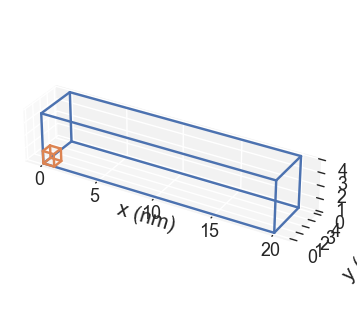

In [463]:
spinchain_mesh.mpl(figsize=(4, 4), multiplier=1e-9)

#### 2.2.3. Field

In [479]:
spinchain_field_m_init = (1, 0, 0)
Ms  = 800e3  # saturisation magnetisation (A/m)
spinchain_num_dims = 3

In [480]:
spinchain_magnetisation_field = df.Field(mesh=spinchain_mesh, 
                                         nvdim=spinchain_num_dims, 
                                         value=spinchain_field_m_init, 
                                         norm=Ms)

C:\Users\Cameron McEleney\PycharmProjects\Ubermag\.venv\Lib\site-packages\matplotlib\quiver.py:649: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
C:\Users\Cameron McEleney\PycharmProjects\Ubermag\.venv\Lib\site-packages\matplotlib\quiver.py:649: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


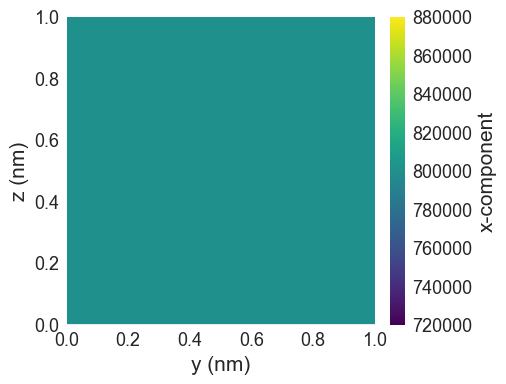

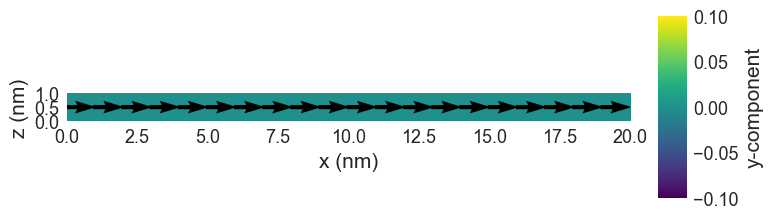

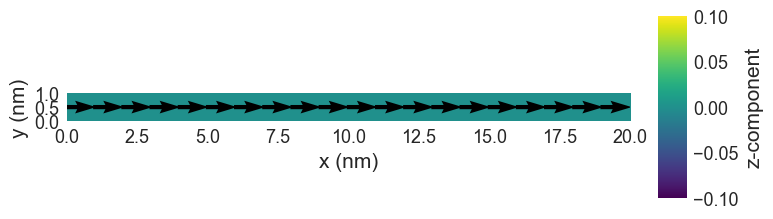

In [436]:
for i in ['x', 'y', 'z']:
    spinchain_magnetisation_field.sel(i).mpl(figsize=(8, 4))

### 2.3. Dynamics equations

In [472]:
spinchain_dynamics_terms = None

#### 2.3.1. Precession term

In [473]:
# Gyrotropic ratio (A s / kg) i.e. (C/kg)
spinchain_gamma = 2 * np.pi * 29.2e9

# Gyromagnetic ratio (m / A s)
spinchain_gamm0 = spinchain_gamma * mm.consts.mu0

In [474]:
spinchain_precession = mm.Precession(gamma0=spinchain_gamm0)

# First DynamicsTerm so we assign instead of append
spinchain_dynamics_terms = spinchain_precession

In [440]:
# Print equation of the precession dynamics term
# spinchain_precession

#### 2.3.2. Damping term

In [475]:
# Gilbert damping factor, alpha (dimensionless)
spinchain_alpha = 1e-4

In [476]:
spinchain_damping_dynamics = mm.Damping(alpha=spinchain_alpha)
spinchain_dynamics_terms += spinchain_damping_dynamics

In [443]:
# Print equation of the damping dynamics term
# spinchain_damping_dynamics

#### 2.3.3. Dynamics equation

In [477]:
spinchain_dynamics = mm.Dynamics(terms=spinchain_dynamics_terms) 

In [478]:
print(f'This dynamics equation has {len(spinchain_dynamics)} terms, and is given by the following equation')

# Print out equation of system's dynamics terms
spinchain_dynamics

This dynamics equation has 2 terms, and is given by the following equation


Precession(gamma0=230553.95880944742) + Damping(alpha=0.0001)

### 2.4. Construct system

[Documentation page](https://ubermag.github.io/api/_autosummary/micromagneticmodel.System.html#micromagneticmodel.System)

In [486]:
#spinchain_system = mm.System(name=spinchain_name,
#                             energy=spinchain_energy,
#                             dynamics=spinchain_dynamics,
#                             m=spinchain_magnetisation_field,
#                             T=0
#                            )
system_spinchain.energy=spinchain_energy
system_spinchain.dynamics=spinchain_dynamics
system_spinchain.m = spinchain_magnetisation_field

## 3. Driving region

## 4. Drivers

### 4.1. Minimise energy

#### 4.1.1. Create driver

In [487]:
mindriver = oc.MinDriver()

#### 4.1.2. Run driver to minimise energy

In [489]:
mindriver.drive(system_spinchain,
                verbose=2)

Running OOMMF (TclOOMMFRunner)[2024/05/17 16:25]... (6.1 s)


#### 4.1.3. Check output (model)

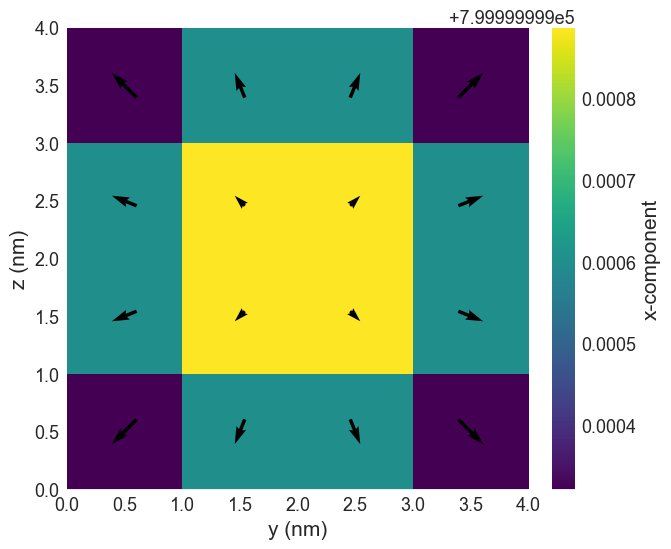

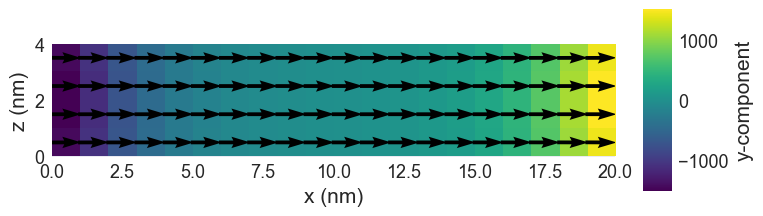

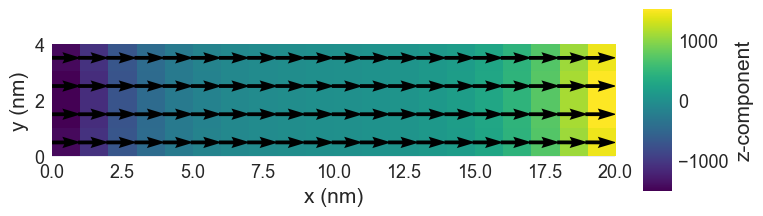

In [491]:
system_spinchain.m.sel('x').mpl()
system_spinchain.m.sel('y').mpl()
system_spinchain.m.sel('z').mpl()

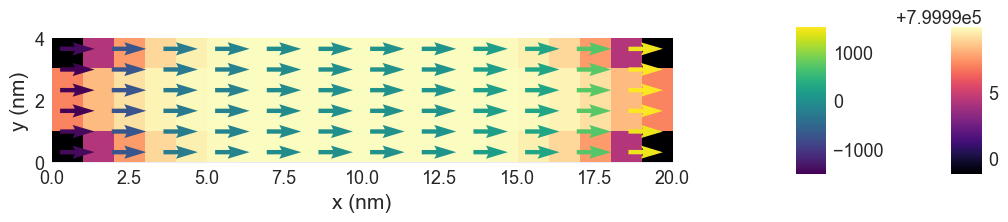

In [492]:
# make figure larger
fig, ax1 = plt.subplots(figsize=(12, 6))

# plot vectors on grid of 20 x 5 over the numerical resulotion
system_spinchain.m.sel('z').resample((12, 6)).mpl.vector(ax=ax1)

# add colouring for mx-component to this plot
system_spinchain.m.x.sel('z').mpl.scalar(ax=ax1, cmap='magma')

#### 4.1.4. Check output (line plot)

In [ ]:
line = spinchain_system.m.line(p1=spinchain_system.m.mesh.region.pmin, p2=spinchain_system.m.mesh.region.pmax, n=19)
line.mpl(marker='o')

### 4.2. Dynamic drive

In [500]:
system_spinchain.energy += spinchain_zeeman_dynamic

In [501]:
system_spinchain.energy += spinchain_zeeman_static

#### 4.2.1. Create driver (TimeDriver)

In [502]:
spinchain_timedriver = oc.TimeDriver()

#### 4.2.2. Run driver

In [503]:
spinchain_time_max = 5e-9  # maximum simulated time (s)
spinchain_num_steps = 100  # number of steps during simulation

print(f'Stepsize, h: {spinchain_time_max/spinchain_num_steps} (s)')

Stepsize, h: 5e-11 (s)


In [504]:
spinchain_timedriver.drive(system_spinchain, 
                           t=spinchain_time_max,
                           n=spinchain_num_steps,
                           verbose=2)

Running OOMMF (TclOOMMFRunner):   0%|          | 0/100 files written [00:00]

Running OOMMF (TclOOMMFRunner)[2024/05/17 16:30] took 650.8 s


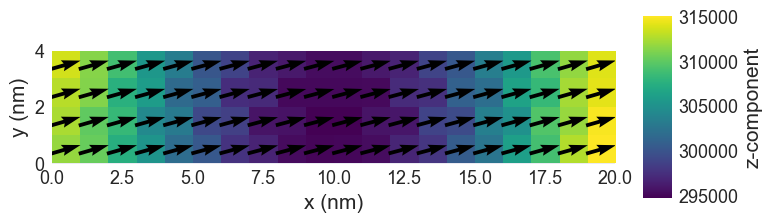

In [505]:
system_spinchain.m.sel('z').mpl()

#### 4.2.3. Plot data (table)

In [ ]:
spinchain_system.table.data

#### 4.2.4. Plot data (graph)

In [ ]:
spinchain_system.table.mpl(y=['mx', 'my', 'mz'])